# Wasserstein Barycenter
install ot packages.

In [1]:
pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

     | 2.8 MB 15.8 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for POT: filename=POT-0.9.2.dev0-cp310-cp310-linux_x86_64.whl size=736027 sha256=edd2e180b72cfafe5dd41da23674a21030c13d29548abde636516ec782d16848
  Stored in directory: /tmp/pip-ephem-wheel-cache-uf60wz6c/wheels/d3/ed/a6/2d2d04d49657eeea50abf2a2eddfcf37290174fa63fe511d6d
Successfully built POT


# Wasserstein Barycenter for 1D distribution

In [2]:
# Import necessary packages.
# generate gauss distribution
import numpy as np
import matplotlib.pylab as pl
import matplotlib as mpl
import torch

from ot.lp import wasserstein_1d
from ot.datasets import make_1D_gauss as gauss
from ot.utils import proj_simplex
red = np.array(mpl.colors.to_rgb('red'))
blue = np.array(mpl.colors.to_rgb('blue'))

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=10)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# enforce sum to one on the support
a = a / a.sum()
b = b / b.sum()



/usr/local/lib/python3.10/dist-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  cws = cws.T.contiguous()


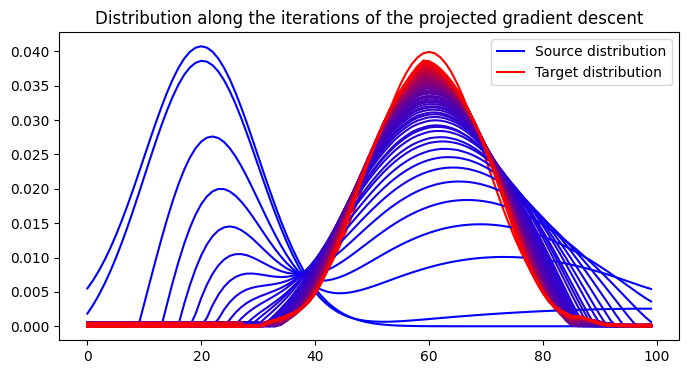

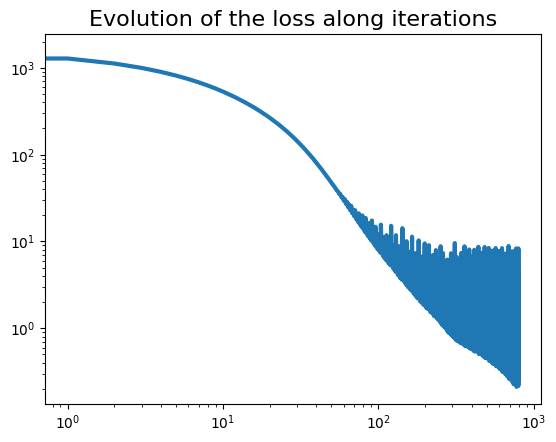

In [3]:
# learn wasserstein barycenter here, for i=1 case
device = "cuda" if torch.cuda.is_available() else "cpu"

# use pyTorch for our data
x_torch = torch.tensor(x).to(device=device)
a_torch = torch.tensor(a).to(device=device).requires_grad_(True)
b_torch = torch.tensor(b).to(device=device)

lr = 1e-6
nb_iter_max = 800

loss_iter = []

pl.figure(1, figsize=(8, 4))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')

for i in range(nb_iter_max):
    # Compute the Wasserstein 1D with torch backend
    loss = wasserstein_1d(x_torch, x_torch, a_torch, b_torch, p=2)
    # record the corresponding loss value
    loss_iter.append(loss.clone().detach().cpu().numpy())
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = a_torch.grad
        a_torch -= a_torch.grad * lr  # step
        a_torch.grad.zero_()
        a_torch.data = proj_simplex(a_torch)  # projection onto the simplex

    # plot one curve every 10 iterations
    if i % 10 == 0:
        mix = float(i) / nb_iter_max
        pl.plot(x, a_torch.clone().detach().cpu().numpy(), c=(1 - mix) * blue + mix * red)

pl.legend()
pl.title('Distribution along the iterations of the projected gradient descent')
pl.show()

pl.figure(2)
pl.loglog(range(nb_iter_max), loss_iter, lw=3)
pl.title('Evolution of the loss along iterations', fontsize=16)
pl.show()

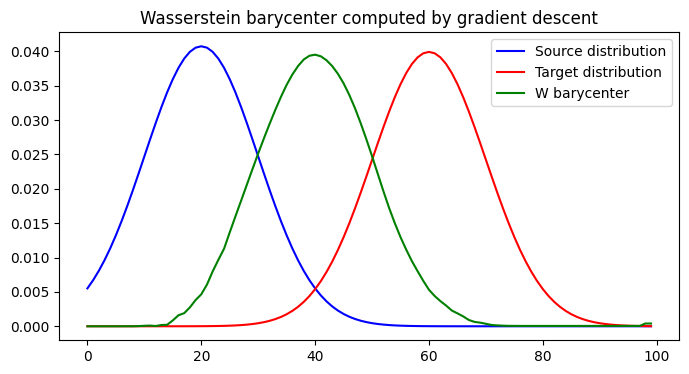

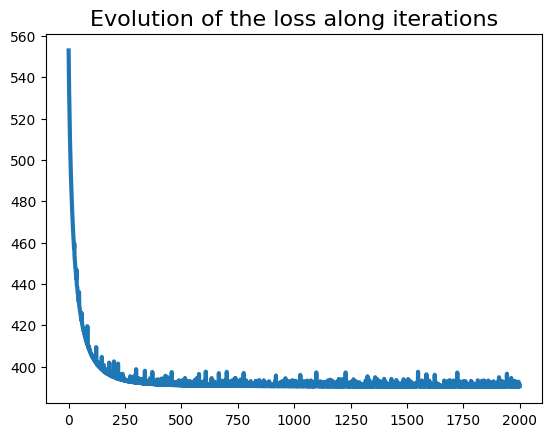

In [ ]:
#wasserstein barycenter for 1D distribution, when n=2.
device = "cuda" if torch.cuda.is_available() else "cpu"

# use pyTorch for our data
x_torch = torch.tensor(x).to(device=device)
a_torch = torch.tensor(a).to(device=device)
b_torch = torch.tensor(b).to(device=device)
bary_torch = torch.tensor((a + b).copy() / 2).to(device=device).requires_grad_(True)


lr = 1e-6
nb_iter_max = 2000

loss_iter = []

# instant of the interpolation
t = 0.5

for i in range(nb_iter_max):
    # Compute the Wasserstein 1D with torch backend
    loss = (1 - t) * wasserstein_1d(x_torch, x_torch, a_torch.detach(), bary_torch, p=2) + t * wasserstein_1d(x_torch, x_torch, b_torch, bary_torch, p=2)
    # record the corresponding loss value
    loss_iter.append(loss.clone().detach().cpu().numpy())
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = bary_torch.grad
        bary_torch -= bary_torch.grad * lr  # step
        bary_torch.grad.zero_()
        bary_torch.data = proj_simplex(bary_torch)  # projection onto the simplex

pl.figure(3, figsize=(8, 4))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.plot(x, bary_torch.clone().detach().cpu().numpy(), c='green', label='W barycenter')
pl.legend()
pl.title('Wasserstein barycenter computed by gradient descent')
pl.show()

pl.figure(4)
pl.plot(range(nb_iter_max), loss_iter, lw=3)
pl.title('Evolution of the loss along iterations', fontsize=16)
pl.show()

# Wasserstein Barycenter for MNIST dataset
load data

In [4]:
# load data
!mkdir ./data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz -P ./data
!tar -zxvf ./data/MNIST.tar.gz -C ./data/

--2023-12-19 00:18:42--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-12-19 00:18:42--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘./data/MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  3.00MB/s    in 8.8s    

2023-12-19 00:18:51 (3.78 MB/s) - ‘./data/MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte

In [5]:
pip install python-mnist

In [6]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import ot
from mnist import MNIST

In [7]:
data = MNIST(path='./data/MNIST/raw', return_type='numpy')
images, labels = data.load_training()
images = images.astype(float).reshape(-1, 28, 28) / 255

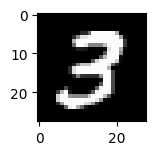

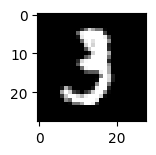

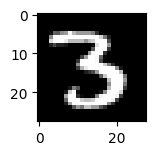

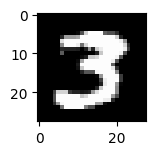

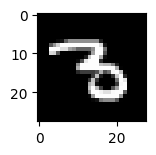

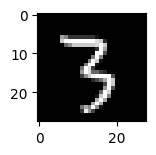

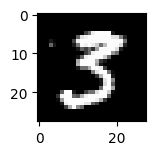

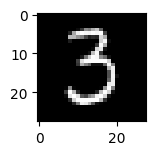

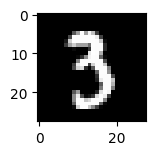

In [14]:
# doing data plot for 3.
X3 = images[labels == 3]
img_list_3 = []
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X3[i], cmap=plt.get_cmap('gray'))
  img_list_3.append(X3[i]/np.sum(X3[i]))
  plt.show()

In [15]:
# select 4 "3"s for plot
A3 = np.array(img_list_3[0:4])
f1 = A3[0]
f2 = A3[1]
f3 = A3[2]
f4 = A3[3]
nb_images = 4

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

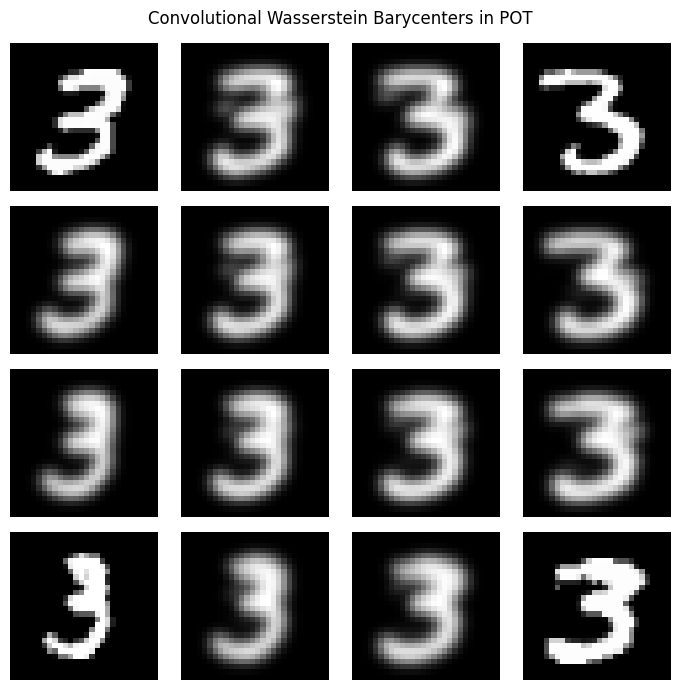

In [16]:
# Wasserstein barycenter plot by varying the weights of images.
fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
plt.suptitle('Convolutional Wasserstein Barycenters in POT')
cm = 'gray'
# regularization parameter
reg = 0.004
for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            axes[i, j].imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes[i, j].imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes[i, j].imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes[i, j].imshow(f4, cmap=cm)
        else:
            # call to barycenter computation
            axes[i, j].imshow(
                ot.bregman.convolutional_barycenter2d(A3, reg, weights),
                cmap=cm
            )
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

## Wasserstein distance vs. empirical mean operation
empirical mean operation take mean for each image

In [17]:

img_list_3 = []
for i in range(100):
  #plt.subplot(330 + 1 + i)
  #plt.imshow(X3[i], cmap=plt.get_cmap('gray'))
  img_list_3.append(X3[i]/np.sum(X3[i]))
  #plt.show()


In [34]:
# return images.
from skimage.transform import resize
def create_digits_image(images, labels, digit=0, grid_size=64, n_digits=15, original_size=28, is_distribution=True):
    batch = images[np.where(labels==digit)[0]]
    images = []
    for i in range(n_digits):
        grid = np.zeros([grid_size, grid_size])
        final_size = np.random.randint(original_size // 2, original_size * 2)
        grid_cells = np.arange(0, grid_size - final_size)
        img = resize(batch[np.random.randint(0, len(batch))], (final_size, final_size))
        p = [10] + [1] * (len(grid_cells) - 2) + [10]
        center_x = np.random.choice(grid_cells, size=1, p=np.array(p) / sum(p))[0]
        center_y = np.random.choice(grid_cells, size=1, p=np.array(p) / sum(p))[0]
        grid[center_x:center_x+final_size, center_y:center_y+final_size] = img.copy()
        if is_distribution:
            grid = grid / np.sum(grid)
        images.append(grid.reshape(1, grid_size, grid_size))
    images = np.array(images).reshape(-1, grid_size ** 2)

    return images

In [35]:
digit = 3
grid_size = 64
n_digits = 15
original_size = 20
is_distribution = True

B = create_digits_image(images, labels,
                        digit=digit,
                        grid_size=grid_size,
                        n_digits=n_digits,
                        original_size=original_size,
                        is_distribution=is_distribution)

(-0.5, 63.5, 63.5, -0.5)

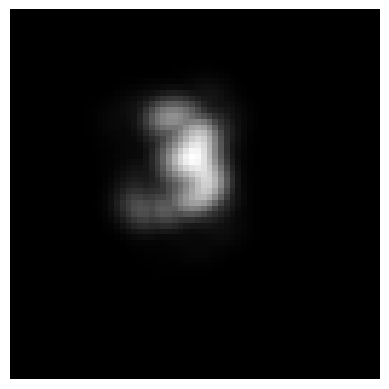

In [44]:
#print(B.shape)
#img_list_3 = np.array(img_list_3)
#print(img_list_3.shape)
B3 = np.array(B.reshape(-1,64,64))
plt.imshow(ot.bregman.convolutional_barycenter2d(B3, 0.0022), cmap = 'gray')
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

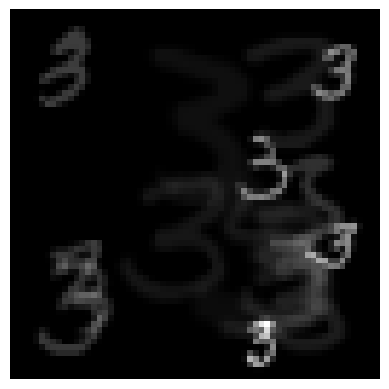

In [22]:
plt.imshow(np.mean(B.reshape(-1, 64, 64),axis =0), cmap='gray')
plt.axis('off')

# FER dataset
facial emotion image data\
load data (upload the zip file into Google drive and then unzip)

In [ ]:
!unzip  /content/drive/MyDrive/FER2013.zip -d /content/drive/MyDrive

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/archive/train/angry/Training_81541574.jpg  
  inflating: /content/drive/MyDrive/__MACOSX/archive/train/angry/._Training_81541574.jpg  
  inflating: /content/drive/MyDrive/archive/train/angry/Training_50120123.jpg  
  inflating: /content/drive/MyDrive/__MACOSX/archive/train/angry/._Training_50120123.jpg  
  inflating: /content/drive/MyDrive/archive/train/angry/Training_60016886.jpg  
  inflating: /content/drive/MyDrive/__MACOSX/archive/train/angry/._Training_60016886.jpg  
  inflating: /content/drive/MyDrive/archive/train/angry/Training_68690730.jpg  
  inflating: /content/drive/MyDrive/__MACOSX/archive/train/angry/._Training_68690730.jpg  
  inflating: /content/drive/MyDrive/archive/train/angry/Training_73515932.jpg  
  inflating: /content/drive/MyDrive/__MACOSX/archive/train/angry/._Training_73515932.jpg  
  inflating: /content/drive/MyDrive/archive/train/angry/Training_32153813.jpg  
  inflating: /content/drive/MyDrive/__

In [45]:
# import necessary packages.
import cv2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import os
import ot
from sklearn import decomposition

In [46]:
train_path = "/content/drive/MyDrive/archive/train"
test_path = "/content/drive/MyDrive/archive/test"
Categories = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
img_size = 64

In [47]:
# data loader.
train_data = []
test_data = []
cat_train = []
cat_test = []
def create_training_data(path, Categories):

    for category in Categories:
        new_path =""
        new_path = os.path.join(path, category)
        class_num = Categories.index(category)

        for img in tqdm(os.listdir(new_path)):

            img_path = os.path.join(new_path,img)
            img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            new_img= cv2.resize(img_read,(img_size,img_size))
            if(path == train_path):
                train_data.append([new_img , class_num])
                cat_train.append(category)
            else:
                test_data.append([new_img , class_num])
                cat_test.append(category)

In [48]:
create_training_data(train_path, Categories)

100%|██████████| 4965/4965 [01:16<00:00, 64.99it/s] 


In [ ]:
len(train_data)
len(cat_train)

57418

In [49]:
x_train , x_test  = [] , []
def extract_splits(data):
    for features ,label  in data  :

        if(data == train_data):
            x_train.append(features)
            y_train.append(label)
        else:
            x_test.append(features)
            y_test.append(label)

In [50]:
extract_splits(train_data)

In [51]:
# data preprcoessing: reshape + normalization.
x_train = np.array(x_train).reshape(-1,img_size,img_size)
x_test = np.array(x_test).reshape(-1,img_size,img_size)

y_train = np.array(y_train)
y_test = np.array(y_test)
x_train ,x_test = x_train/255.0 ,  x_test/255.0

## Data Plotting

happy


(-0.5, 63.5, 63.5, -0.5)

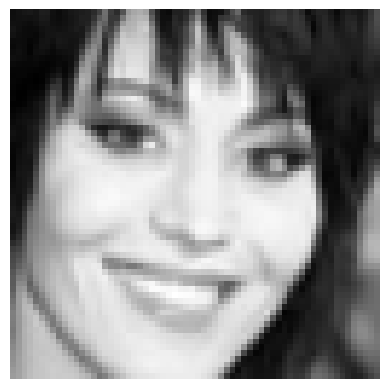

In [55]:
plt.imshow(x_train[10414],cmap = 'gray')
print(Categories[y_train[10414]])
plt.axis('off')

angry


(-0.5, 63.5, 63.5, -0.5)

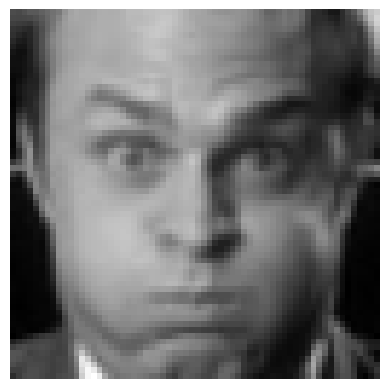

In [56]:
plt.imshow(x_train[10],cmap = 'gray')
print(Categories[y_train[10]])
plt.axis('off')

disgust


(-0.5, 63.5, 63.5, -0.5)

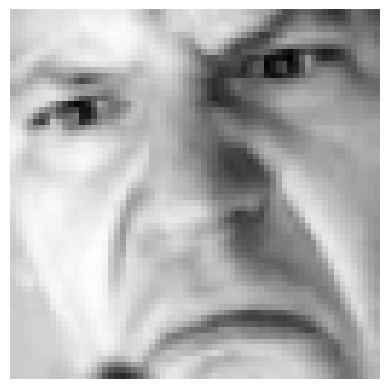

In [103]:
plt.imshow(x_train[4000],cmap = 'gray')
print(Categories[y_train[4000]])
plt.axis('off')

In [148]:
# 'happy = 3', 'angry =0 ', 'disgust = 1'
index = []
for i in range(len(y_train)):
  if y_train[i] == 3:
    index.append(i)


# Wasserstein barycenter plot
sample random images from a certain class to compute the wasserstein barycenter.

In [149]:
x_train_happy = x_train[index,:,:]
y_train_happy = y_train[index]

In [150]:
sample_index = np.random.randint(len(y_train_happy),size = 30)

In [151]:
print(sample_index)

[3768  781 5767 2820 4255 4442 7023 4576 3938 6089 1252 1397 5441 2513
 5798 6086 2335 3109 5411 6197 5455 1301 6115 6522 6242 2096 5143 1464
  850 6569]


In [152]:
sample_image = x_train_happy[sample_index,:,:]
sample_image = sample_image.astype('float64')

In [153]:
result = ot.bregman.convolutional_barycenter2d_debiased(sample_image, 0.0015, numItermax = 500)

/usr/local/lib/python3.10/dist-packages/ot/bregman/_convolutional.py:405: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(-0.5, 63.5, 63.5, -0.5)

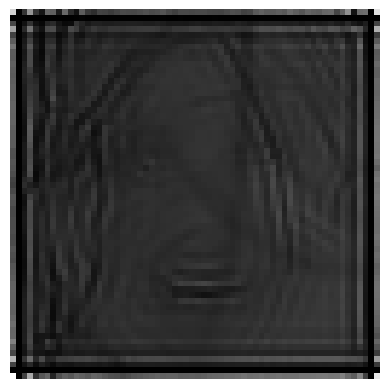

In [154]:
plt.imshow(result,cmap = 'gray' )
plt.axis('off')

### PCA analysis

In [155]:
#print(sample_image.dtype)
sample_image_reduction = []
for i in range(len(sample_index)):
  pca = decomposition.PCA(n_components=1).fit(sample_image[i,:,:])
  image_reduction = pca.components_
  sample_image_reduction.append(image_reduction)

In [156]:
sample_image_reduction = np.array(sample_image_reduction).reshape((len(sample_index),img_size))
print(sample_image_reduction.shape)

(30, 64)


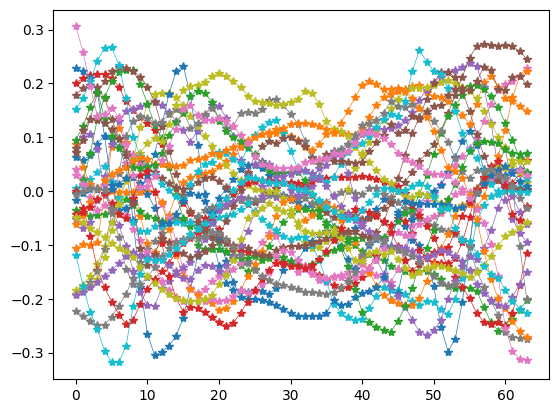

In [157]:
for i in range(len(sample_index)):
  plt.plot(sample_image_reduction[i,:],'-*',linewidth=0.5)